<a href="https://colab.research.google.com/github/andy-nguyen-21/BrazilianE-Commerce/blob/main/E_commerce_data_analyst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
My name is [Andy Nguyen](https://www.linkedin.com/in/dung-nguyen-012/).
This is a project I am practicing my data analytics skills using a Brazilian e-commerce public dataset of orders made at [Olist Store](http://www.olist.com/).

---
Data source: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data

# Database Schema Diagram
![Alt text](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2473556%2F23a7d4d8cd99e36e32e57303eb804fff%2Fdb-schema.png?generation=1714391550829633&alt=media)
Source: [Terenci Claramunt](https://www.kaggle.com/datasets/terencicp/e-commerce-dataset-by-olist-as-an-sqlite-database/data)

In [1]:
import kagglehub
import os
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Add a linear regression line (trend line) to scatter plot
from sklearn.linear_model import LinearRegression

# This downloads the dataset and returns the path to the downloaded folder
print("Downloading raw e-commerce data...")
download_path = kagglehub.dataset_download('olistbr/brazilian-ecommerce')
print(f"Download complete. Files are in: {download_path}")

# Create a new SQLite database
db_path = 'brazilian_ecommerce.sqlite'
db_connection = sqlite3.connect(db_path)
print(f"Created new database: {db_path}")

# List of CSV files and their corresponding table names
csv_files = {
    'olist_customers_dataset.csv': 'customers',
    'olist_geolocation_dataset.csv': 'geolocation',
    'olist_orders_dataset.csv': 'orders',
    'olist_order_items_dataset.csv': 'order_items',
    'olist_order_payments_dataset.csv': 'order_payments',
    'olist_order_reviews_dataset.csv': 'order_reviews',
    'olist_products_dataset.csv': 'products',
    'olist_sellers_dataset.csv': 'sellers',
    'product_category_name_translation.csv': 'product_category_name_translation'
}

# Loop through each CSV file and import it into a new table
for csv_file, table_name in csv_files.items():
    file_path = os.path.join(download_path, csv_file)
    if os.path.exists(file_path):
        print(f"Importing {csv_file} into table {table_name}...")
        df = pd.read_csv(file_path)
        df.to_sql(table_name, db_connection, if_exists='replace', index=False)
        print(f"Import of {table_name} complete.")
    else:
        print(f"Warning: {csv_file} not found at {file_path}. Skipping.")

print("All data imported")

Download complete. Files are in: /kaggle/input/brazilian-ecommerce
Created new database: brazilian_ecommerce.sqlite
Importing olist_customers_dataset.csv into table customers...
Import of customers complete.
Importing olist_geolocation_dataset.csv into table geolocation...
Import of geolocation complete.
Importing olist_orders_dataset.csv into table orders...
Import of orders complete.
Importing olist_order_items_dataset.csv into table order_items...
Import of order_items complete.
Importing olist_order_payments_dataset.csv into table order_payments...
Import of order_payments complete.
Importing olist_order_reviews_dataset.csv into table order_reviews...
Import of order_reviews complete.
Importing olist_products_dataset.csv into table products...
Import of products complete.
Importing olist_sellers_dataset.csv into table sellers...
Import of sellers complete.
Importing product_category_name_translation.csv into table product_category_name_translation...
Import of product_category_name

# Connect To The Database
The sqlite3 library allows us to query the database using python without a dedicated server running on the background.

Create `view_table()`: easily view a limited number of rows from any SQLite table as a pandas DataFrame.

In [2]:
def view_table(table, row_limit):
  query = f"""
    SELECT *
    FROM {table}
    LIMIT {row_limit}
  """
  return pd.read_sql_query(query, db_connection)

# Orders Volume Trend


## Order Growth Over Time

In [3]:
print("The first 4 columns of 'orders' table:")
view_table('orders', 5).iloc[:, :4]

The first 4 columns of 'orders' table:


,order_id,customer_id,order_status,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39


In [4]:
print("The remaining columns of 'orders' table:")
view_table('orders', 5).iloc[:, 4:]

The remaining columns of 'orders' table:


,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
print("""Calculate the total orders per day:
Note: I filter out orders before 2017-01, and after 2018-08 due to suspected missing data """)
oders_per_day_query = """
SELECT
  strftime('%Y-%m-%d', order_purchase_timestamp) AS order_date,
  COUNT(*) AS order_count,
  strftime('%Y-%m', order_purchase_timestamp) AS year_month
FROM
  orders
WHERE
  order_status = 'delivered'
  AND order_purchase_timestamp >= '2017-01-01' -- Filter out orders before 2017-01,
  AND order_purchase_timestamp < '2018-08-01'  -- and after 2018-08 due to suspected missing data
GROUP BY
  order_date
ORDER BY
  order_date;
"""
orders_per_day = pd.read_sql_query(oders_per_day_query, db_connection)
orders_per_day.head(5)

Calculate the total orders per day:
Note: I filter out orders before 2017-01, and after 2018-08 due to suspected missing data 


,order_date,order_count,year_month
0,2017-01-05,32,2017-01
1,2017-01-06,4,2017-01
2,2017-01-07,4,2017-01
3,2017-01-08,4,2017-01
4,2017-01-09,5,2017-01


Generating plot:


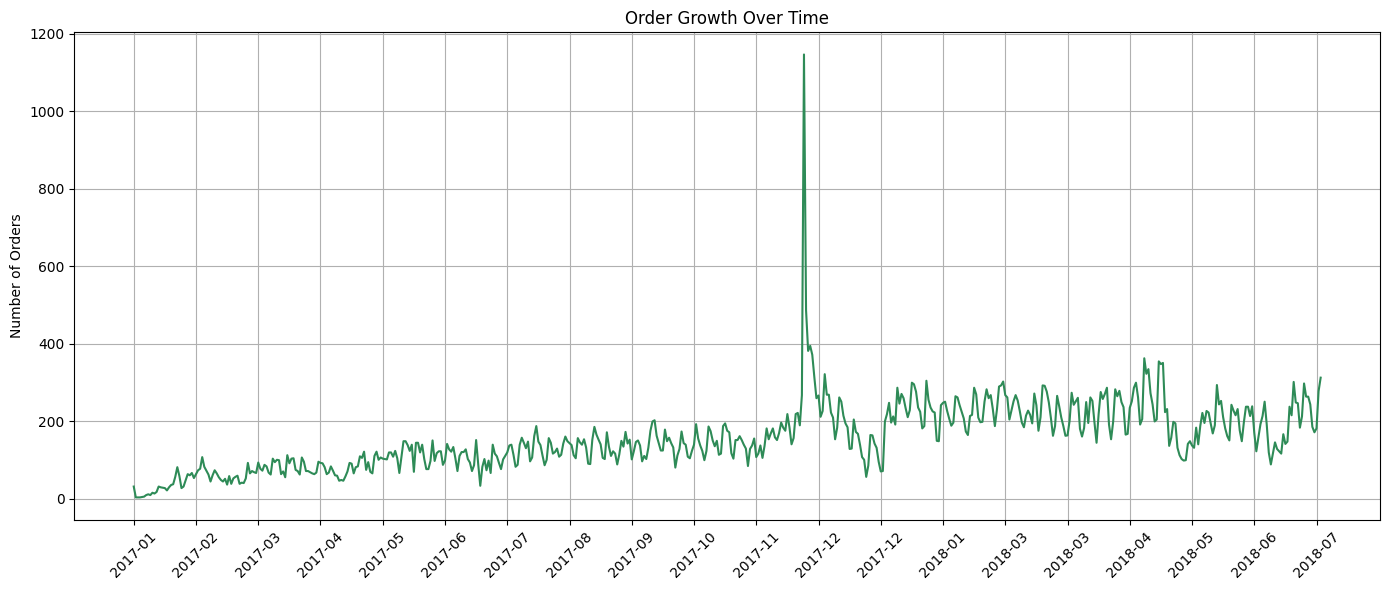

In [6]:
print("Generating plot:")

plt.figure(figsize=(14, 6)) # Use plt.figure to set the figure size
plt.plot(orders_per_day.index, orders_per_day['order_count'], color='seagreen') # Plot against the index
plt.ylabel('Number of Orders')
plt.title('Order Growth Over Time')

# Set the x-axis ticks and labels
plt.xticks(orders_per_day.index[::30], orders_per_day['year_month'][::30], rotation=45) # Use year_month for labels, show every 30th tick

plt.grid(True) # Add a grid for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

- **Overall Trend:**
General upward trend in the number of orders per day from beginning 2017 through most of 2018. This suggests the e-commerce platform was growing during this period.
- **Seasonality/Peaks:**
There are noticeable peaks in the number of order. This could be due to various factors like holiday shopping seasons such as Black Friday or Christmas  or specific marketing campaigns.
- **Variability:** There is daily variability in the number of orders, which is expected. Some days have significantly more orders than others.

## Daily and Hourly Order Trends

In [7]:
print("""Determine weekday and hour of day of the order:""")
oders_by_weekday_and_hour_query = """
SELECT
  order_purchase_timestamp,
  strftime('%w', order_purchase_timestamp) AS week_day,
  strftime('%H', order_purchase_timestamp) AS hour_of_day
FROM
  orders
WHERE
  order_status = 'delivered'
  AND order_purchase_timestamp >= '2017-01-01' -- Filter out orders before 2017-01,
  AND order_purchase_timestamp < '2018-08-01'  -- and after 2018-08 due to suspected missing data
ORDER BY
  order_purchase_timestamp;
"""
oders_by_weekday_and_hour = pd.read_sql_query(oders_by_weekday_and_hour_query, db_connection)
oders_by_weekday_and_hour.head(5)

Determine weekday and hour of day of the order:


,order_purchase_timestamp,week_day,hour_of_day
0,2017-01-05 11:56:06,4,11
1,2017-01-05 12:01:20,4,12
2,2017-01-05 12:06:36,4,12
3,2017-01-05 12:09:08,4,12
4,2017-01-05 12:11:23,4,12


In [8]:
print("Create heatmap dataframe")
heat_map_query = """
  SELECT
    strftime('%w', order_purchase_timestamp) AS week_day,
    strftime('%H', order_purchase_timestamp) AS hour_of_day,
    COUNT(*) AS order_count
  FROM
    orders
  GROUP BY
    week_day, hour_of_day
  ORDER BY
    week_day, hour_of_day;
"""

heatmap = pd.read_sql_query(heat_map_query, db_connection)

# Map day numbers to names for better readability
name_week_day = {
    '0': 'Sunday', '1': 'Monday', '2': 'Tuesday', '3': 'Wednesday',
    '4': 'Thursday', '5': 'Friday', '6': 'Saturday'
}

heatmap['week_day'] = heatmap['week_day'].map(name_week_day)

# Pivot the DataFrame to create a matrix
pivot_heatmap = heatmap.pivot_table(index='week_day', columns='hour_of_day', values='order_count', fill_value=0)
display(pivot_heatmap)

Create heatmap dataframe


hour_of_day,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
week_day,,,,,,,,,,,,,,,,,,,,,
Friday,426.0,216.0,72.0,49.0,40.0,36.0,97.0,206.0,493.0,768.0,...,961.0,979.0,974.0,817.0,723.0,784.0,738.0,726.0,702.0,512.0
Monday,328.0,134.0,66.0,36.0,21.0,22.0,69.0,160.0,479.0,783.0,...,1096.0,1079.0,1094.0,992.0,928.0,945.0,1027.0,1118.0,991.0,717.0
Saturday,315.0,175.0,67.0,43.0,25.0,24.0,53.0,106.0,249.0,434.0,...,677.0,722.0,697.0,701.0,710.0,756.0,730.0,654.0,550.0,429.0
Sunday,267.0,141.0,69.0,44.0,27.0,27.0,34.0,105.0,205.0,349.0,...,684.0,716.0,712.0,797.0,895.0,899.0,967.0,889.0,873.0,607.0
Thursday,355.0,167.0,75.0,39.0,31.0,28.0,85.0,220.0,502.0,758.0,...,977.0,928.0,1077.0,909.0,784.0,826.0,839.0,840.0,857.0,551.0
Tuesday,306.0,158.0,80.0,28.0,29.0,24.0,71.0,223.0,522.0,864.0,...,1124.0,1047.0,1081.0,967.0,877.0,924.0,988.0,1027.0,965.0,692.0
Wednesday,397.0,179.0,81.0,33.0,33.0,27.0,93.0,211.0,517.0,829.0,...,1050.0,983.0,1040.0,967.0,852.0,848.0,904.0,963.0,878.0,615.0


Generating heatmap:


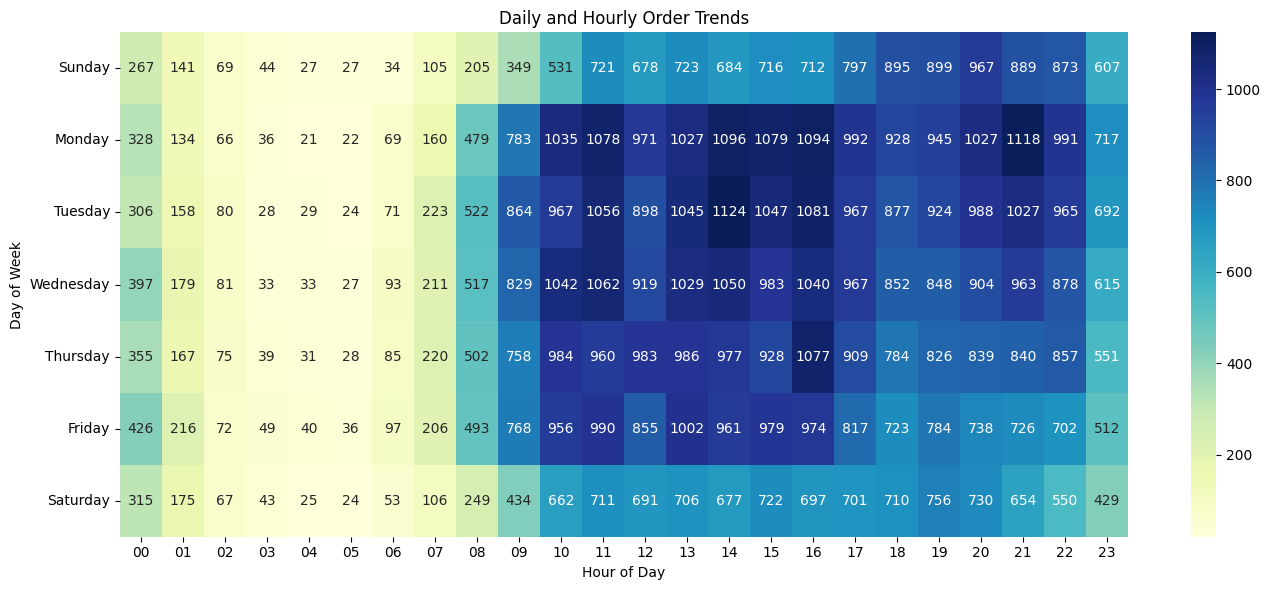

In [9]:
print("Generating heatmap:")
# Reorder the days of the week
reorder_week_day = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
pivot_heatmap = pivot_heatmap.reindex(reorder_week_day)

# Create the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_heatmap, cmap='YlGnBu', annot=True, fmt='g')

plt.title('Daily and Hourly Order Trends')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()

The heatmap illustrates the distribution of orders throughout the week and across different hours of the day.
* **Overall Trend:**
1.  A prominent trend is the concentration of orders during
weekday working hours (9AM-5PM). Following a slight dip, order volume surges again in the evening, reaching another peak between 7 PM and midnight.
2.  Weekends have significantly lower order volume which could indicate a shift to in-store shopping or other activities.
3.  The lowest activity is consistently during sleep hours, with minimal orders from 3AM to 6 AM.
* **Variability:**
1. An unusual spike occurs at midnight, potentially driven by 24-hour sales or late-night promotions.
2. Orders on Thursday and Friday nights are approximately 20% lower than the average for other weekdays during the same hours.



## States States with the Most Orders

In [10]:
# Preview Orders table:
view_table('orders', 5).iloc[:, :4]

,order_id,customer_id,order_status,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39


In [11]:
# Preview Customers table:
view_table('customers', 5).iloc[:, :5]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [12]:
# Find TOP 10 States of Order volume:
top_10_state_querry = """
  SELECT *
  FROM
    (
    SELECT
      customer_state,
      COUNT(*) AS order_count
    FROM
      orders
      JOIN customers USING (customer_id)
    GROUP BY
      customer_state
    ORDER BY
      order_count DESC
    LIMIT 10
    )
  ORDER BY
    order_count
"""
top_10_state = pd.read_sql_query(top_10_state_querry, db_connection)

# Transfer State abbreviations to State names for better readability:

brazilian_state_names = {
    'SP': 'São Paulo',
    'RJ': 'Rio de Janeiro',
    'MG': 'Minas Gerais',
    'RS': 'Rio Grande do Sul',
    'PR': 'Paraná',
    'SC': 'Santa Catarina',
    'BA': 'Bahia',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'PE': 'Pernambuco',
    'CE': 'Ceará',
    'PA': 'Pará',
    'MT': 'Mato Grosso',
    'MA': 'Maranhão',
    'MS': 'Mato Grosso do Sul',
    'PB': 'Paraíba',
    'PI': 'Piauí',
    'RN': 'Rio Grande do Norte',
    'AL': 'Alagoas',
    'SE': 'Sergipe',
    'TO': 'Tocantins',
    'RO': 'Rondônia',
    'AM': 'Amazonas',
    'AC': 'Acre',
    'AP': 'Amapá',
    'RR': 'Roraima'
}

top_10_state['customer_state'] = top_10_state['customer_state'].map(brazilian_state_names)
print("TOP 10 States by Order volume:")
top_10_state

TOP 10 States by Order Volumn:


,customer_state,order_count
0,Goiás,2020
1,Espírito Santo,2033
2,Distrito Federal,2140
3,Bahia,3380
4,Santa Catarina,3637
5,Paraná,5045
6,Rio Grande do Sul,5466
7,Minas Gerais,11635
8,Rio de Janeiro,12852
9,São Paulo,41746


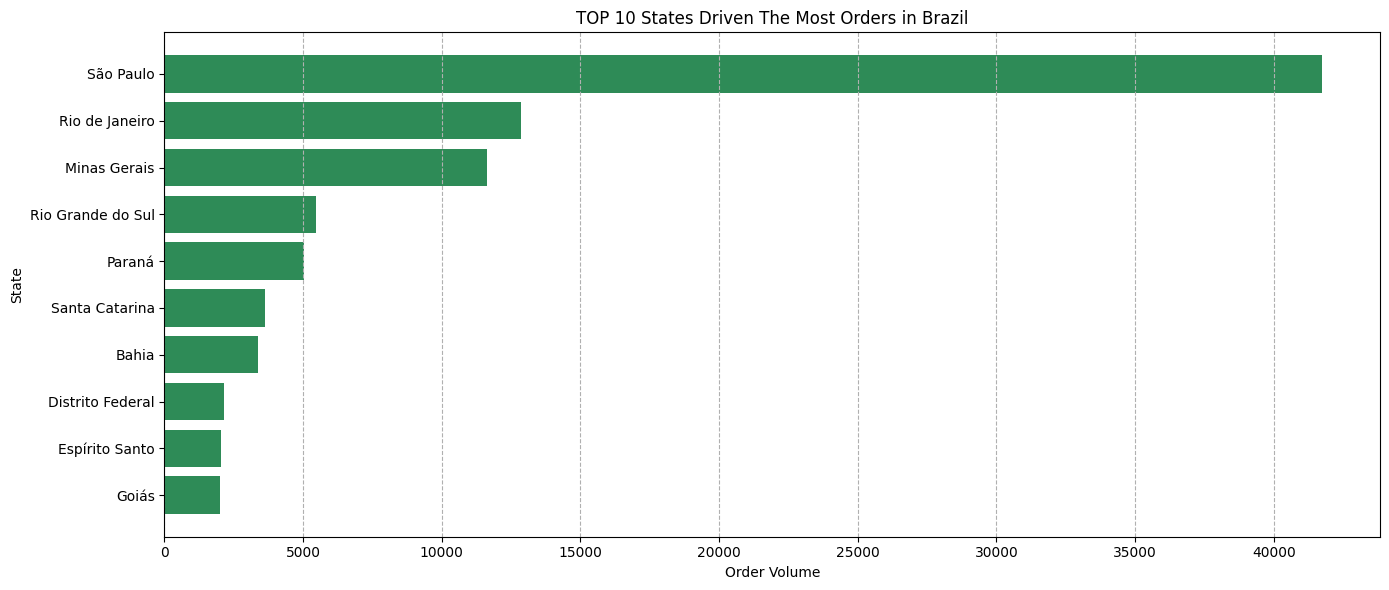

In [13]:
# Create bar chart for top 10 states by order volume
plt.figure(figsize=(14, 6))
plt.barh(top_10_state['customer_state'], top_10_state['order_count'], color='seagreen')
plt.xlabel('Order Volume')
plt.ylabel('State')
plt.title('Top 10 States with the Most Orders in Brazil')

plt.tight_layout()
plt.grid(axis='x', linestyle='--')
plt.show()

This graph depicts Top 10 state with the Most Orders.

*   **Key Observations and Potential Insights:**


1.   The top 3 states, São Paulo, Rio de Janeiro, and Minas Gerais, exhibit significantly higher order volumes compared to the rest (Geolocation data backup required. I just google these cities are really the biggest).
2.   The substantial order volume in São Paulo, in particular, suggests there may be specific factors contributing to its success. Further exploration into demographics, local infrastructure, or targeted marketing campaigns in São Paulo could reveal strategies applicable to boosting order volume in other states and potentially creating similar "success stories."





# Order Items Pricing

In [14]:
view_table('order_items', 5).iloc[:, :3]

,order_id,order_item_id,product_id
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089


In [15]:
view_table('order_items', 5).iloc[:, 3:]

,seller_id,shipping_limit_date,price,freight_value
0,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [16]:
product_and_freight_cost_query = """
  SELECT
    order_id,
    SUM(price) AS total_price,
    SUM(freight_value) AS total_freight,
    COUNT(*) AS item_count
  FROM
    order_items
  GROUP BY
    order_id

"""

product_and_freight_cost = pd.read_sql_query(product_and_freight_cost_query, db_connection)
product_and_freight_cost.head(5)

,order_id,total_price,total_freight,item_count
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,1
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,1
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,1
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,1


## Product Amount per Order  
Let's see how many items customers usually order:


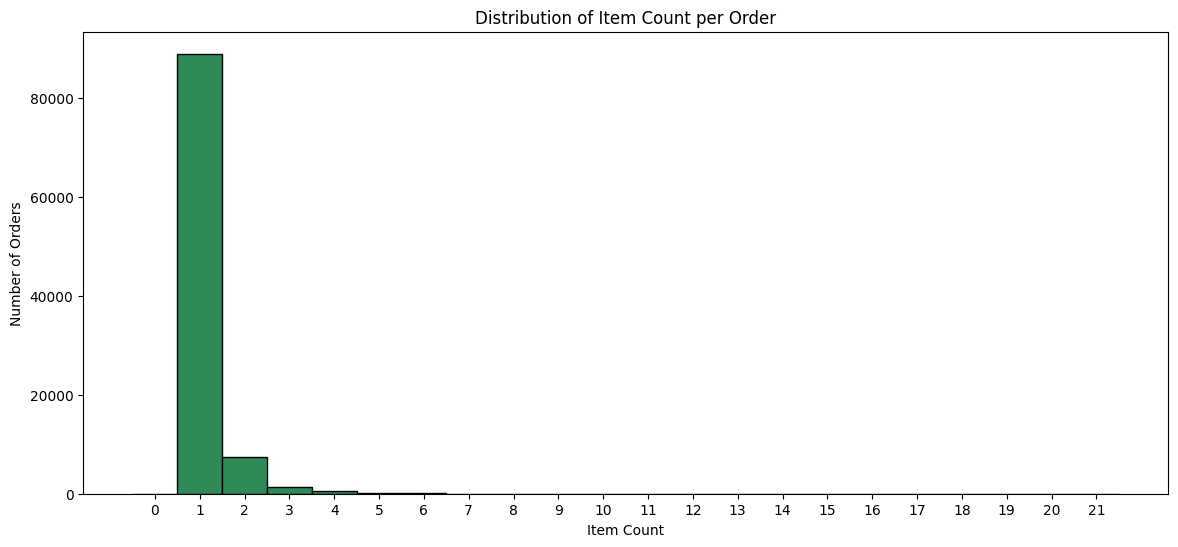

In [17]:
# Generating histogram plot on item_count per order_id
plt.figure(figsize=(14, 6))

# Set bins to be centered around integers
max_item_count = int(product_and_freight_cost['item_count'].max())
bins = range(0, max_item_count + 2) # Create bins that are centered around integers

plt.hist(product_and_freight_cost['item_count'], bins=bins, color='seagreen', edgecolor='black', align='left') # Use align='left' or 'mid' depending on desired centering

plt.xlabel('Item Count')
plt.ylabel('Number of Orders')
plt.title('Distribution of Item Count per Order')


# Set x-axis ticks to be integers and centered
plt.xticks(range(0, max_item_count + 1))

plt.show()

**Observations and Potential Insights:**  
*   The graph reveals a strong preference for single-item purchases. A significant drop-off in order volume occurs with multi-item orders, highlighting that customers are less likely to buy multiple products in a single transaction.
*   There are a small number of orders with a considerably higher item count, suggesting occasional bulk purchases or specific product types that are bought in larger quantities.
*   Understanding this preference for single-item orders is crucial for optimizing inventory management, shipping costs, and marketing strategies aimed at increasing the average order value.



## Order Volume Relation with Order Value and Freight Cost

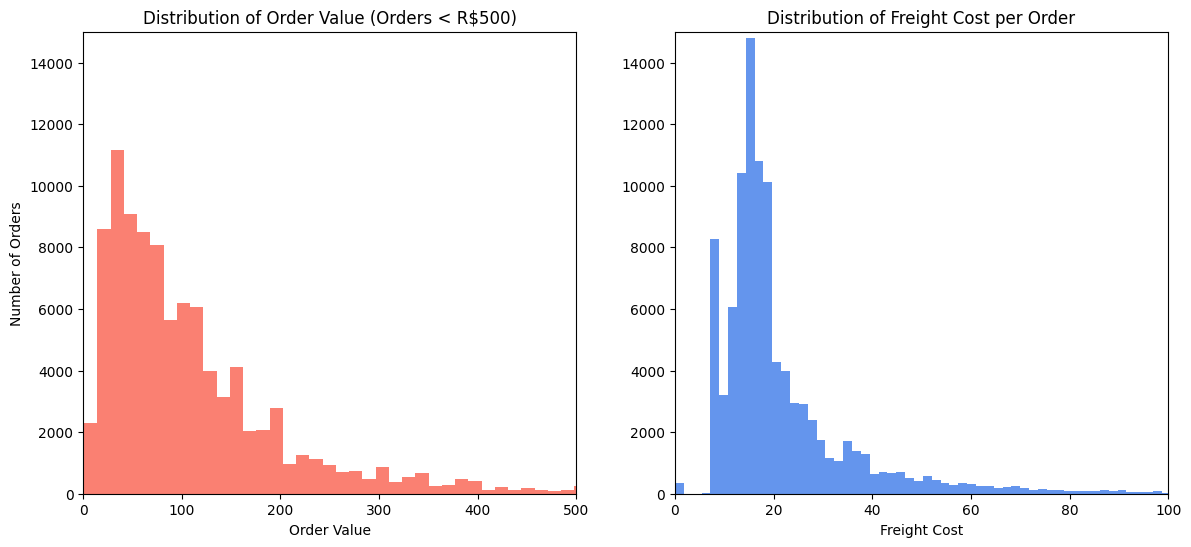

In [18]:
plt.figure(figsize=(14, 6))

# Generating product pricing range by order plot
plt.subplot(1, 2, 1)
plt.hist(product_and_freight_cost['total_price'], bins=1000, color='salmon') # Increased bins for better detail in the limited range

plt.xlabel('Order Value')
plt.ylabel('Number of Orders')
plt.title('Distribution of Order Value (Orders < R$500)') # Updated title

plt.xlim(0, 500) # Set the x-axis limit to 500
plt.ylim(0, 15000) # Set the y-axis limit to 15000

#Generating freight fee by order plot
plt.subplot(1, 2, 2)
plt.hist(product_and_freight_cost['total_freight'], bins=1000, color='cornflowerblue') # Increased bins for better detail in the limited range

plt.xlabel('Freight Cost')
plt.title('Distribution of Freight Cost per Order')

plt.xlim(0, 100) # Set the x-axis limit to 100
plt.ylim(0, 15000) # Set the y-axis limit to 15000

plt.show()

**Observations and Potential Insights:**  
*   The highest volume of orders are concentrated around 80 Real, with the majority of transactions falling below 200 Real. The distribution is heavily skewed towards lower order values, indicating that most customers purchase items with a relatively low total price.
*   Similarly, freight costs are substantially concentrated between 10  Real and 20 Real, suggesting a common range for shipping fees. The number of orders decreases significantly for higher freight costs. This distribution could be influenced by factors such as shipping distance and product weight.
*   Understanding these pricing distributions is important for pricing strategies, shipping options, and potentially identifying opportunities to encourage higher-value orders or optimize freight costs.


# Revenue Breakdown by Category  
This analysis explores customer preferences across product categories by examining both sales value and transaction volume.

In [19]:
view_table('order_items', 5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [20]:
# JOIN 3 tables: order_items, product_category_name_translation, products
product_category_in_order_query = ("""
    SELECT
      order_id,
      order_item_id,
      product_category_name_english,
      price
    FROM
      order_items
      JOIN products USING (product_id)
      JOIN product_category_name_translation USING (product_category_name)
    ORDER BY
      order_id
""")
product_category_in_order = pd.read_sql_query(product_category_in_order_query, db_connection)
product_category_in_order.head(5)

,order_id,order_item_id,product_category_name_english,price
0,00010242fe8c5a6d1ba2dd792cb16214,1,cool_stuff,58.90
1,00018f77f2f0320c557190d7a144bdd3,1,pet_shop,239.90
2,000229ec398224ef6ca0657da4fc703e,1,furniture_decor,199.00
3,00024acbcdf0a6daa1e931b038114c75,1,perfumery,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,garden_tools,199.90


## Sales Value

In [21]:
# Prepare datatable:
category_value_tree_map_query = f"""
  SELECT
    product_category_name_english,
    SUM(price) AS total_value
  FROM
    ({product_category_in_order_query})
  GROUP BY
    product_category_name_english
"""
category_value_tree_map = pd.read_sql_query(category_value_tree_map_query, db_connection)
category_value_tree_map.head(5)

# Create treemap:
import plotly.express as px

# Label improving: Capitalize the first letter and remove under score
category_value_tree_map['product_category_name_english_cleaned'] = category_value_tree_map['product_category_name_english'].str.replace('_', ' ').str.title()

# Create treemap for category sale value
fig = px.treemap(
    category_value_tree_map,
    path=['product_category_name_english_cleaned'],
    values='total_value',
    title='Sales Breakdown by Category',
    color='total_value', # Color the treemap based on total_value
    hover_data=['total_value'], # Add total_value to hover information
    color_continuous_scale='Viridis' # Use a different color scale
)

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25)) # Adjust layout margins

fig.show()

## Items Volume

In [22]:
# Prepare data table:
category_order_count_tree_map_query = f"""
  SELECT
    product_category_name_english,
    COUNT(*) AS item_count
  FROM
    ({product_category_in_order_query})
  GROUP BY
    product_category_name_english
"""
category_order_count_tree_map = pd.read_sql_query(category_order_count_tree_map_query, db_connection)
category_order_count_tree_map.head(5)

# Label improving: Capitalize the first letter and remove under score
category_order_count_tree_map['product_category_name_english_cleaned'] = category_value_tree_map['product_category_name_english'].str.replace('_', ' ').str.title()

# Create treemap for category item count
fig = px.treemap(
    category_order_count_tree_map,
    path=['product_category_name_english_cleaned'],
    values='item_count',
    title='Item Count Breakdown by Category',
    color='item_count', # Color the treemap based on item_count
    hover_data=['item_count'], # Add item_count to hover information
    color_continuous_scale='Viridis' # Use a different color scale
)

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25)) # Adjust layout margins

fig.show()


## Relation of Sale Value and Product Volume by Category

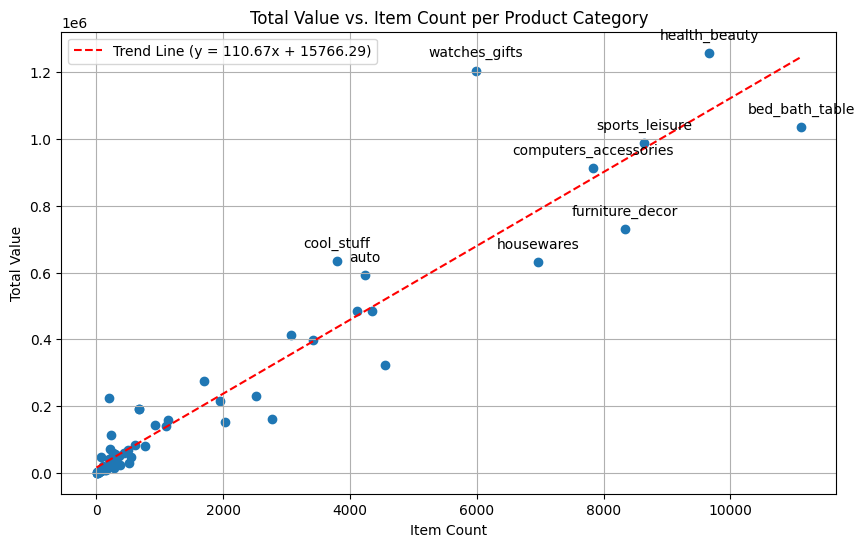

In [23]:
# JOIN 2 treemap tables
joined_category_tables_query = f"""
    SELECT
      *
    FROM
      ({category_value_tree_map_query})
      JOIN ({category_order_count_tree_map_query}) USING (product_category_name_english)
"""
joined_category_tables = pd.read_sql_query(joined_category_tables_query, db_connection)
joined_category_tables.head(5)

# Create linear plot between category value and item count

plt.figure(figsize=(10, 6)) # Increase figure size for better readability
plt.scatter(joined_category_tables.item_count, joined_category_tables.total_value)
plt.xlabel('Item Count')
plt.ylabel('Total Value')
plt.title('Total Value vs. Item Count per Product Category') # Add a title
plt.grid(True) # Add a grid for easier reading of values

# Add a linear regression line (trend line)

# Reshape data for linear regression
X = joined_category_tables['item_count'].values.reshape(-1, 1)
y = joined_category_tables['total_value'].values.reshape(-1, 1)

# Fit the linear model
model = LinearRegression()
model.fit(X, y)

# Predict values for the trend line
trend_X = np.array([X.min(), X.max()]).reshape(-1, 1)
trend_y = model.predict(trend_X)

plt.plot(trend_X, trend_y, color='red', linestyle='--', label=f'Trend Line (y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f})')
plt.legend()

# Label categories with item_count > 5k or total_value > 0.5M
for i, row in joined_category_tables.iterrows():
    if row['item_count'] > 5000 or row['total_value'] > 500000:
        plt.annotate(row['product_category_name_english'], (row['item_count'], row['total_value']), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

**Observation:**
* The treemaps effectively highlight the dominance of a few product categories in terms of both sales value and item count (like 'health_beauty', 'bed_bath_table', 'sports_leisure', 'watches_gifts', 'computers_accessories', 'furniture_decor', 'housewares', and 'auto').
* The scatter plot confirms the generally linear relationship between item count and total value across categories, indicating that categories with more items sold tend to generate higher revenue.

**Potential Analysis**
* Deep dive into Top categories: best-sellings, average order value by category.
* Price distribution of products within high-performing and low-performing categories.
* Temporal Trends within Categories such as seasonal trends or freight cost or growth patterns.

## Product Weight on Sales Performance

In [24]:
# Select Sales Category > 400.000 Real
top_sales_category_name_query = f"""
  SELECT
    product_category_name_english,
    total_value
  FROM
    ({joined_category_tables_query})
  WHERE
    total_value > 400000
  ORDER BY
    total_value DESC
"""
top_sales_category_name = pd.read_sql_query(top_sales_category_name_query, db_connection)
top_sales_category_name.head(5)

# Generating dataframe for boxplot chart
product_weight_on_sales_query = f"""
    SELECT
      product_id,
      product_category_name_english,
      product_weight_g,
      order_item_id
    FROM
      order_items
      JOIN products USING (product_id)
      JOIN product_category_name_translation USING (product_category_name)
    WHERE
      product_category_name_english IN (SELECT product_category_name_english FROM ({top_sales_category_name_query}))
"""
product_weight_on_sales = pd.read_sql_query(product_weight_on_sales_query, db_connection)
product_weight_on_sales.head(5)

,product_id,product_category_name_english,product_weight_g,order_item_id
0,00210e41887c2a8ef9f791ebc780cc36,health_beauty,300.0,1
1,00210e41887c2a8ef9f791ebc780cc36,health_beauty,300.0,1
2,00210e41887c2a8ef9f791ebc780cc36,health_beauty,300.0,1
3,00210e41887c2a8ef9f791ebc780cc36,health_beauty,300.0,1
4,00210e41887c2a8ef9f791ebc780cc36,health_beauty,300.0,1


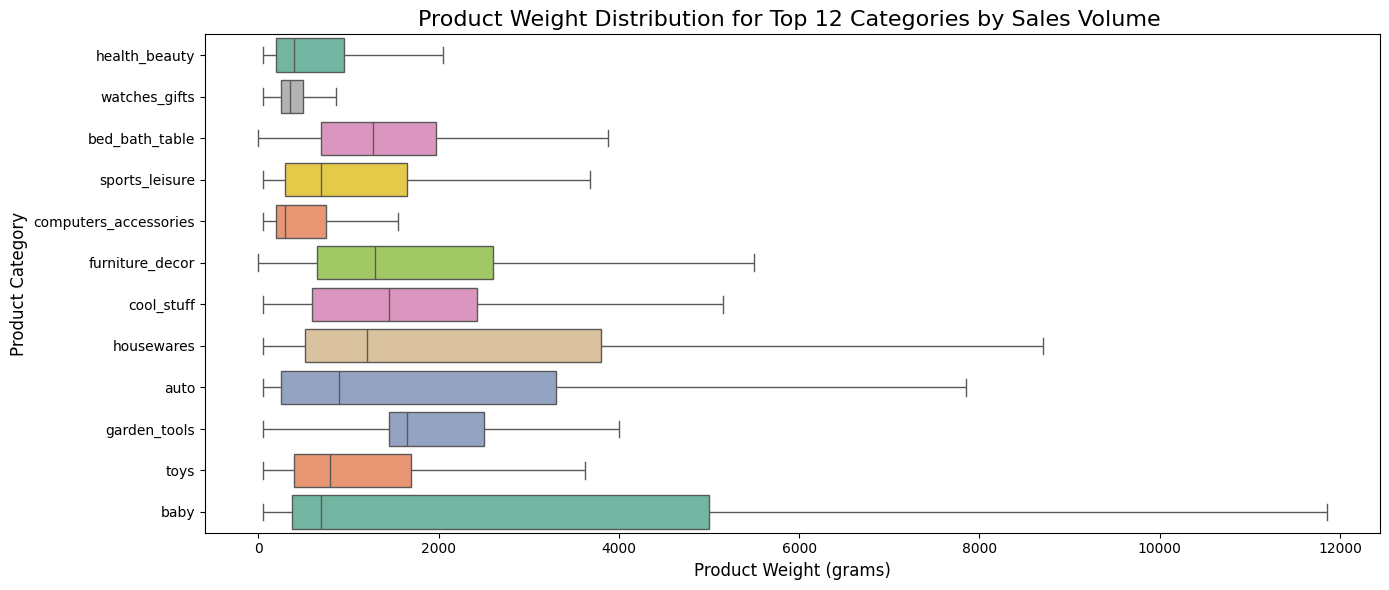

In [25]:
# Sort the Product Category by ...
mapping_category = top_sales_category_name['product_category_name_english']
mapping_category

# Create boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=product_weight_on_sales,
    x='product_weight_g',
    y='product_category_name_english',
    palette='Set2',
    hue='product_category_name_english',
    showfliers=False,
    order=mapping_category,
    legend=False
)
plt.xticks(rotation=90)


# Set labels and titles
plt.title('Product Weight Distribution for Top 12 Categories by Sales Volume ', fontsize=16)
plt.xlabel('Product Weight (grams)', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

**Observations:**


*   Categories with typically heavier items like furniture, housewares, auto, and baby products tend to have higher median weights, as expected.
*   Considering all the medians show customer preferences on light products that under 2000g.
*   The longer whiskers extending to the right for certain categories indicate that there's a portion of products in those categories with significantly higher weights compared to the majority.

**Potential Analysis:**
*   Customer sensitivity to heavier shipping costs.

# Product Weight and Freight Cost Relationship
Analyze the relationship between product weight and freight cost, and investigate customer sensitivity to heavier shipping based on the provided dataset.

## Extract relevant data

### Subtask:
Retrieve product weight and freight cost information for each order item.


**Reasoning**:
Retrieve product weight and freight cost information for each order item by joining the `order_items` and `products` tables.



In [26]:
product_weight_freight_query = """
    SELECT
      oi.product_id,
      p.product_weight_g,
      oi.freight_value,
      oi.order_item_id
    FROM
      order_items oi
      JOIN products p ON oi.product_id = p.product_id
"""

product_weight_freight = pd.read_sql_query(product_weight_freight_query, db_connection)
product_weight_freight.head()

,product_id,product_weight_g,freight_value,order_item_id
0,4244733e06e7ecb4970a6e2683c13e61,650.0,13.29,1
1,e5f2d52b802189ee658865ca93d83a8f,30000.0,19.93,1
2,c777355d18b72b67abbeef9df44fd0fd,3050.0,17.87,1
3,7634da152a4610f1595efa32f14722fc,200.0,12.79,1
4,ac6c3623068f30de03045865e4e10089,3750.0,18.14,1


## Analyze relationship

### Subtask:
Explore the correlation between product weight and freight cost using visualizations (e.g., scatter plot) and potentially statistical methods.


**Reasoning**:
Create a scatter plot to visualize the relationship between product weight and freight cost and calculate the correlation coefficient.



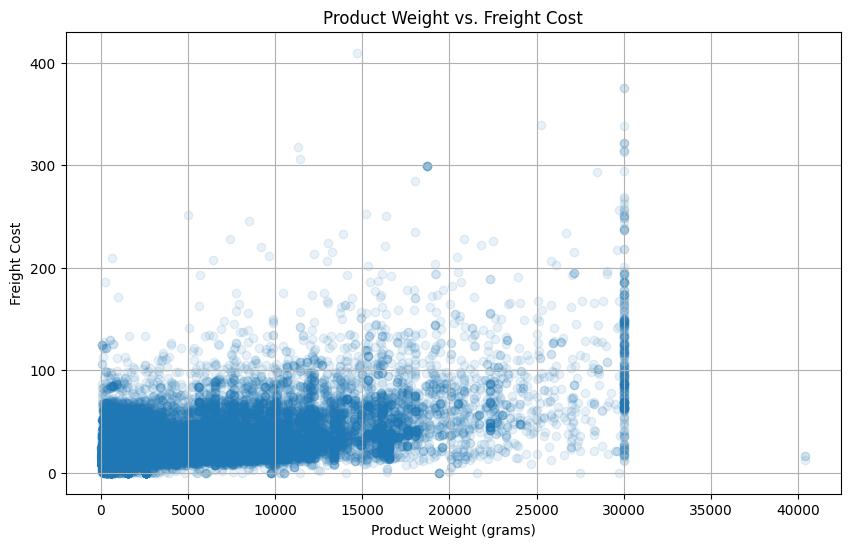

Correlation between product weight and freight cost: 0.61


In [27]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(product_weight_freight['product_weight_g'], product_weight_freight['freight_value'], alpha=0.1)
plt.xlabel('Product Weight (grams)')
plt.ylabel('Freight Cost')
plt.title('Product Weight vs. Freight Cost')
plt.grid(True)
plt.show()

# Calculate the correlation coefficient
correlation = product_weight_freight['product_weight_g'].corr(product_weight_freight['freight_value'])
print(f"Correlation between product weight and freight cost: {correlation:.2f}")

## Analyze freight cost by category

### Subtask:
Investigate the distribution of freight costs within the top sales categories, similar to how you analyzed product weight.


**Reasoning**:
Filter the `product_weight_freight` DataFrame to include only the top sales categories and then create a boxplot to visualize the distribution of freight values for these categories.



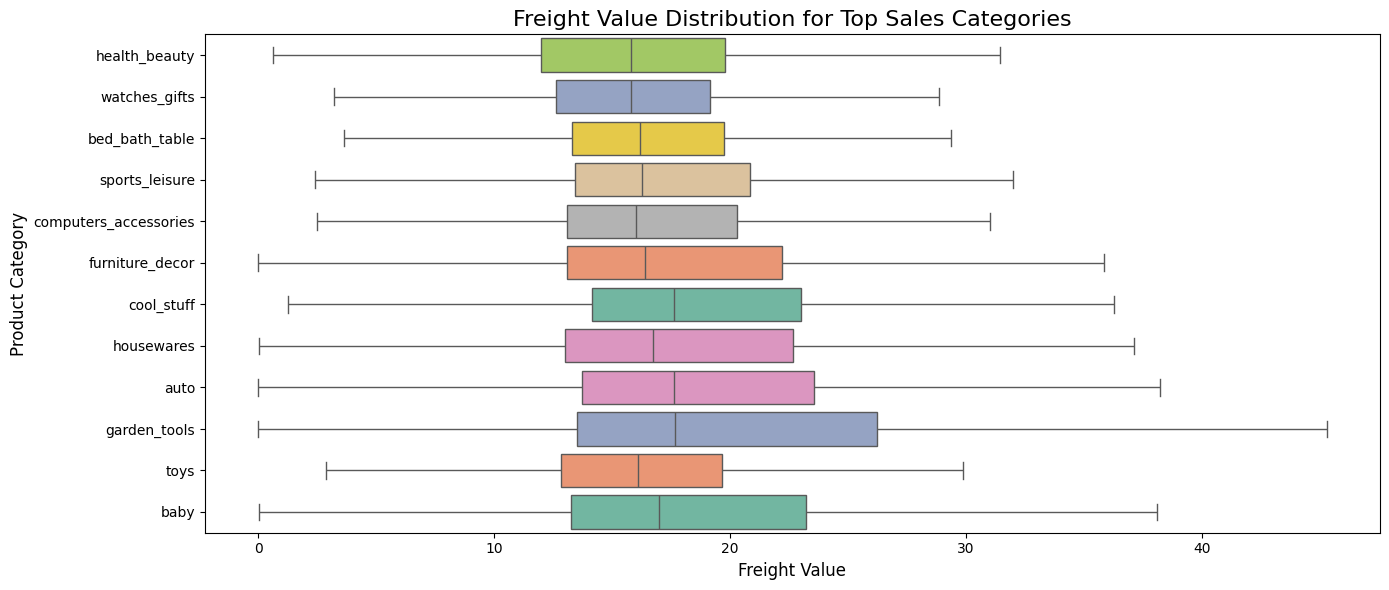

In [28]:
# Join order_items, products, and product_category_name_translation to get category and weight information
product_weight_category_freight_query = """
    SELECT
      oi.product_id,
      p.product_weight_g,
      oi.freight_value,
      oi.order_item_id,
      pct.product_category_name_english
    FROM
      order_items oi
      JOIN products p ON oi.product_id = p.product_id
      JOIN product_category_name_translation pct ON p.product_category_name = pct.product_category_name
"""

product_weight_category_freight = pd.read_sql_query(product_weight_category_freight_query, db_connection)

# Filter the product_weight_category_freight DataFrame to include only the top sales categories
filtered_product_weight_category_freight = product_weight_category_freight[
    product_weight_category_freight['product_category_name_english'].isin(mapping_category)
]

# Create boxplot for freight value distribution
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=filtered_product_weight_category_freight,
    x='freight_value',
    y='product_category_name_english',
    palette='Set2',
    hue='product_category_name_english',
    showfliers=False,
    order=mapping_category,
    legend=False
)

# Set labels and titles
plt.title('Freight Value Distribution for Top Sales Categories', fontsize=16)
plt.xlabel('Freight Value', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Analyze customer behavior

### Subtask:
If possible with the dataset, analyze if there is a drop-off in order volume for heavier items or higher freight costs within specific categories.


**Reasoning**:
Join the necessary tables to get order status, product category, product weight, and freight value for delivered orders. Then, group by category and product weight bins to count orders and prepare for visualization.



In [29]:
# Join filtered_product_weight_category_freight DataFrame with order_items table to get order_id
# Need to query order_items again to ensure we have order_id for the join
order_items_df = pd.read_sql_query("SELECT order_id, order_item_id, product_id FROM order_items", db_connection)

merged_df = pd.merge(filtered_product_weight_category_freight, order_items_df, on=['product_id', 'order_item_id'], how='inner')

# Join the result with the orders DataFrame
orders_df = pd.read_sql_query("SELECT order_id, order_status FROM orders", db_connection)
merged_df = pd.merge(merged_df, orders_df, on='order_id', how='inner')

# Filter for delivered orders
delivered_orders = merged_df[merged_df['order_status'] == 'delivered'].copy()

# Define weight bins based on the previous box plot (e.g., 0-1000g, 1000-5000g, >5000g)
weight_bins = [0, 1000, 5000, delivered_orders['product_weight_g'].max()]
weight_labels = ['0-1kg', '1-5kg', '>5kg']

# Create a new column for weight bins
delivered_orders['weight_bin'] = pd.cut(
    delivered_orders['product_weight_g'],
    bins=weight_bins,
    labels=weight_labels,
    right=False, # Use right=False to include the left edge in the bin
    include_lowest=True # Include the lowest value in the first bin
)

# Group by category and weight bin and count orders
order_count_by_weight = delivered_orders.groupby(['product_category_name_english', 'weight_bin']).size().unstack(fill_value=0)

# Display the resulting dataframe
display(order_count_by_weight)

/tmp/ipython-input-2933160245.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



weight_bin,0-1kg,1-5kg,>5kg
product_category_name_english,,,
auto,17663,16715,13359
baby,24560,3361,11621
bed_bath_table,76153,253600,36220
computers_accessories,203338,8654,98709
cool_stuff,14635,93861,11495
furniture_decor,34466,222045,8453
garden_tools,7085,398837,60214
health_beauty,379512,44579,2405
housewares,24666,20218,37023


**Reasoning**:
Visualize the order count per weight bin for each of the top sales categories using a bar plot to identify any drop-off in order volume as product weight increases.



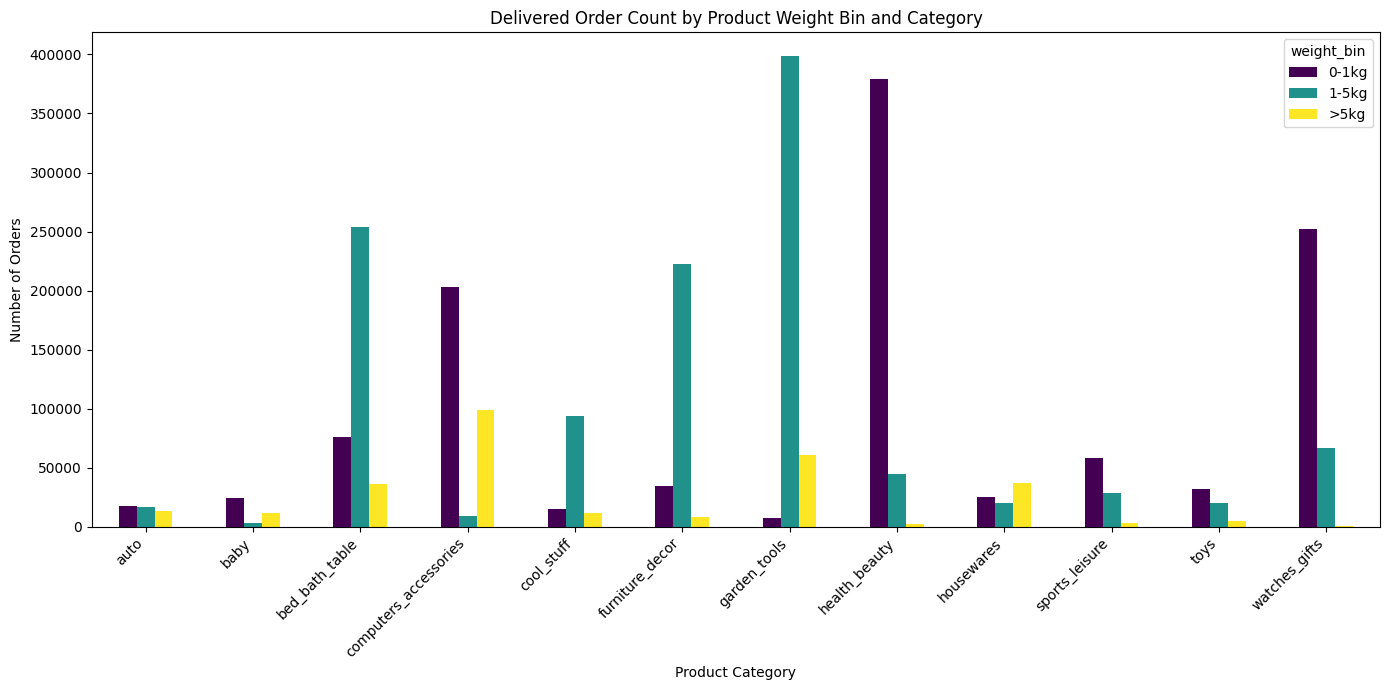

In [30]:
# Visualize the order count per weight bin for each category
order_count_by_weight.plot(kind='bar', figsize=(14, 7), colormap='viridis')

plt.title('Delivered Order Count by Product Weight Bin and Category')
plt.xlabel('Product Category')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
Group the filtered delivered orders DataFrame by product category and freight cost bins to count orders and prepare for visualization.



In [31]:
# Define freight cost bins based on the previous histogram (e.g., 0-10, 10-20, >20)
freight_bins = [0, 10, 20, 50, delivered_orders['freight_value'].max()] # Adjusted bins for better distribution visibility
freight_labels = ['0-10', '10-20', '20-50', '>50']

# Create a new column for freight bins
delivered_orders['freight_bin'] = pd.cut(
    delivered_orders['freight_value'],
    bins=freight_bins,
    labels=freight_labels,
    right=False, # Use right=False to include the left edge in the bin
    include_lowest=True # Include the lowest value in the first bin
)

# Group by category and freight bin and count orders
order_count_by_freight = delivered_orders.groupby(['product_category_name_english', 'freight_bin']).size().unstack(fill_value=0)

# Display the resulting dataframe
display(order_count_by_freight)

/tmp/ipython-input-4222715829.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



freight_bin,0-10,10-20,20-50,>50
product_category_name_english,,,,
auto,6253,22830,17369,1285
baby,5730,22367,9889,1556
bed_bath_table,22385,255217,85671,2709
computers_accessories,27631,124014,129143,29913
cool_stuff,4330,79056,31566,5039
furniture_decor,42786,147164,71625,3389
garden_tools,24419,306075,118604,17038
health_beauty,83825,236322,95281,11068
housewares,6943,46662,25873,2429


**Reasoning**:
Visualize the order count per freight cost bin for each of the top sales categories using a bar plot to analyze how order volume changes with freight cost. Then conclude the analysis of the relationship between product weight and freight cost, and customer sensitivity to heavier shipping, and report the successful completion of the subtask.



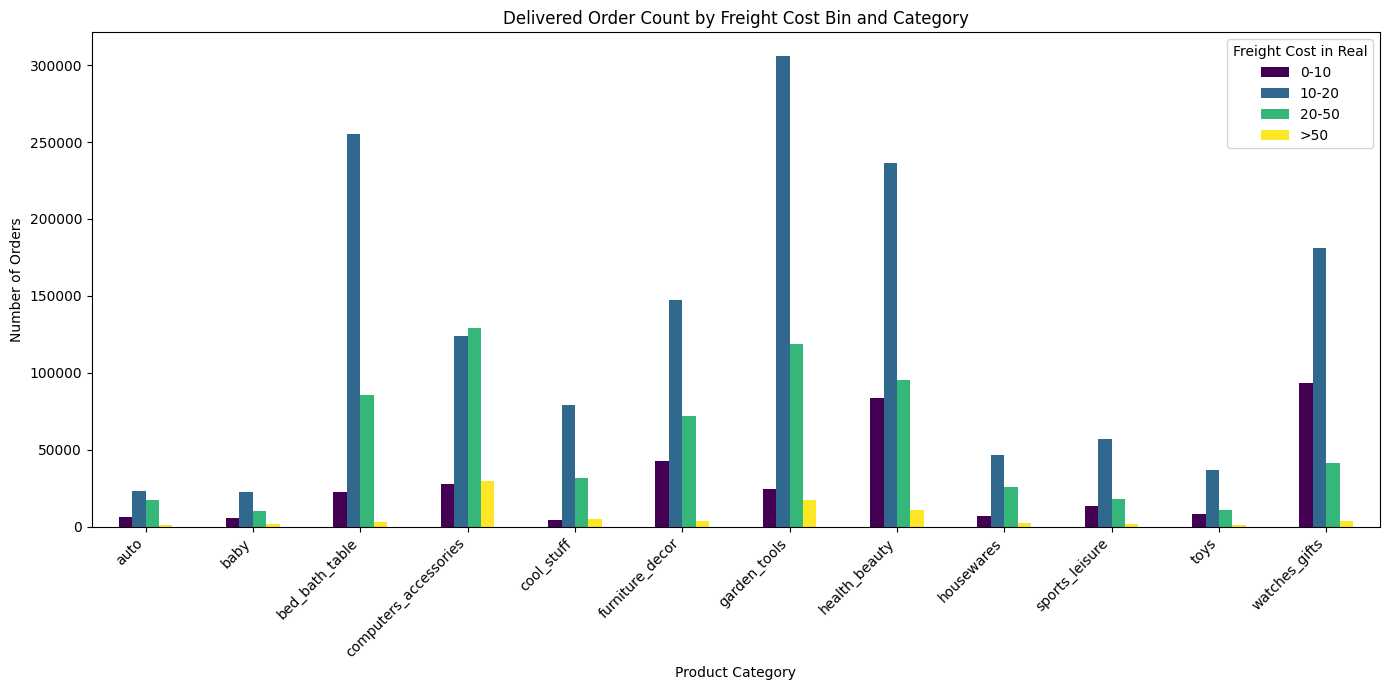

In [32]:
# Visualize the order count per freight bin for each category
order_count_by_freight.plot(kind='bar', figsize=(14, 7), colormap='viridis').legend_.set_title('Freight Cost in Real')

plt.title('Delivered Order Count by Freight Cost Bin and Category')
plt.xlabel('Product Category')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   Moderate Correlation: A moderate positive linear correlation (approximately 0.61) exists between product weight and freight cost. While heavier products generally have higher shipping expenses, other factors also play a significant role.

*   Varied Cost Distribution: The distribution of freight costs varies widely by category. Categories with lighter items, such as 'health_beauty' and 'watches_gifts', have lower median freight costs. In contrast, heavier categories like 'furniture_decor', 'housewares', and 'auto' show higher and more variable shipping costs.

*   Customer Sensitivity to Shipping: Overall order volume trends show a strong customer preference for lighter products (0-1kg bin) and lower freight costs (0-10 and 10-20 bins). This sensitivity leads to a noticeable drop-off in sales for heavier items (>5kg bin) and higher freight costs (>50 bin) across many categories.

*   Categories with Low Sensitivity: Some categories, including 'garden_tools', 'bed_bath_table', and 'computers_accessories', maintain substantial order volumes even with higher weight and freight costs. This suggests that the perceived value or necessity of these products makes customers less sensitive to shipping expenses.

### Conclusion

The data indicates that while there is a general customer sensitivity to heavier shipping costs, this sensitivity is not universal. It is more pronounced in categories with typically lighter, less essential items. The analysis of order volume patterns reinforces the core finding that a product's characteristics and its associated shipping cost directly influence sales, but customer willingness to pay can be mitigated by the product's perceived value.

### Insights or Next Steps

*   Retailers could consider strategies like tiered shipping costs or free shipping thresholds, potentially category-specific, to mitigate customer sensitivity to freight costs, especially for lighter items where sensitivity is higher.
*   Further analysis into the specific product types within categories that maintain high order volume despite higher weight/freight costs could provide insights into perceived customer value or necessity that overrides shipping cost concerns.


# Order Timestamp

## First Glance

In [33]:
view_table('orders', 5).iloc[:,:4]

,order_id,customer_id,order_status,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39


In [34]:
print("order_estimated_delivery_date shows the estimated delivery date that was informed to customer at the purchase moment.")
view_table('orders', 5).iloc[:,4:]

order_estimated_delivery_date shows the estimated delivery date that was informed to customer at the purchase moment.


,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


## Prepare data for visualizations

In [35]:
# Create Total fulfillment time and Est of fulfillment time
avg_time_to_delivery_query = """
    SELECT
      customer_state,
      AVG(CAST((julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp)) AS INTEGER)) AS avg_time_to_delivery,
      AVG(CAST((julianday(order_estimated_delivery_date) - julianday(order_purchase_timestamp)) AS INTEGER)) AS avg_ets_time_to_delivery
    FROM
      orders
      JOIN customers USING (customer_id)
    WHERE
      order_status = 'delivered'
      AND order_delivered_customer_date IS NOT NULL
    GROUP BY
      customer_state
"""
avg_time_to_delivery = pd.read_sql_query(avg_time_to_delivery_query, db_connection)

# Adjust state names for better Readability
avg_time_to_delivery['customer_state']=avg_time_to_delivery['customer_state'].map(brazilian_state_names)

# Filter top 10 states by Sales Volume
avg_time_to_delivery = avg_time_to_delivery[avg_time_to_delivery['customer_state'].isin(top_10_state['customer_state'])]

avg_time_to_delivery.head(5)


,customer_state,avg_time_to_delivery,avg_ets_time_to_delivery
4,Bahia,18.866400,29.073096
6,Distrito Federal,12.509135,23.947115
7,Espírito Santo,15.331830,25.220050
8,Goiás,15.150741,26.721513
10,Minas Gerais,11.542188,24.187951


In [36]:
# Calculate total processing time by each stage
order_time_by_stage_query = """
    SELECT
      customer_state,
      AVG(CAST((julianday(order_approved_at) - julianday(order_purchase_timestamp)) AS INTEGER)) AS avg_time_to_approved,
      AVG(CAST((julianday(order_delivered_carrier_date) - julianday(order_approved_at)) AS INTEGER)) AS avg_time_to_carrier,
      AVG(CAST((julianday(order_delivered_customer_date) - julianday(order_delivered_carrier_date)) AS INTEGER)) AS avg_time_to_delivery
    FROM
      orders
      JOIN customers USING (customer_id)
    WHERE
      order_status = 'delivered'
      AND order_delivered_customer_date IS NOT NULL
    GROUP BY
      customer_state
"""
order_time_by_stage = pd.read_sql_query(order_time_by_stage_query, db_connection)

# Adjust state names for better Readability
order_time_by_stage['customer_state']=order_time_by_stage['customer_state'].map(brazilian_state_names)

# Filter top 10 states by Sales Volume
order_time_by_stage = order_time_by_stage[order_time_by_stage['customer_state'].isin(top_10_state['customer_state'])]

# Rename columns to remove underscores for better legend readability
order_time_by_stage = order_time_by_stage.rename(columns={
    'avg_time_to_approved': 'Purchased to Approved',
    'avg_time_to_carrier': 'Approved to Carrier',
    'avg_time_to_delivery': 'Carrier to Delivery'
})


order_time_by_stage.head(5)

,customer_state,Purchased to Approved,Approved to Carrier,Carrier to Delivery
4,Bahia,0.311118,2.315111,15.585688
6,Distrito Federal,0.275000,2.262500,9.351923
7,Espírito Santo,0.282206,2.452632,11.959398
8,Goiás,0.322432,2.153296,11.984670
10,Minas Gerais,0.256101,2.332306,8.324291


In [67]:
# Create avarage delivery time by day
avg_delivery_time_by_day_query = """
    SELECT
      DATE(order_delivered_customer_date) AS date,
      AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)) AS avg_delivery_time
    FROM
      orders
    WHERE
      order_status = 'delivered'
      AND order_delivered_customer_date IS NOT NULL
      AND DATE(order_delivered_customer_date) >= '2017-01-01'
      AND DATE(order_delivered_customer_date) <= '2018-06-30'
    GROUP BY
      date
"""
avg_delivery_time_by_day = pd.read_sql_query(avg_delivery_time_by_day_query, db_connection)

avg_delivery_time_by_day.head(5)

,date,avg_delivery_time
0,2017-01-11,6.054155
1,2017-01-12,5.481647
2,2017-01-13,6.530250
3,2017-01-16,10.346026
4,2017-01-17,10.608457


## Actual vs. Estimated Delivery Time

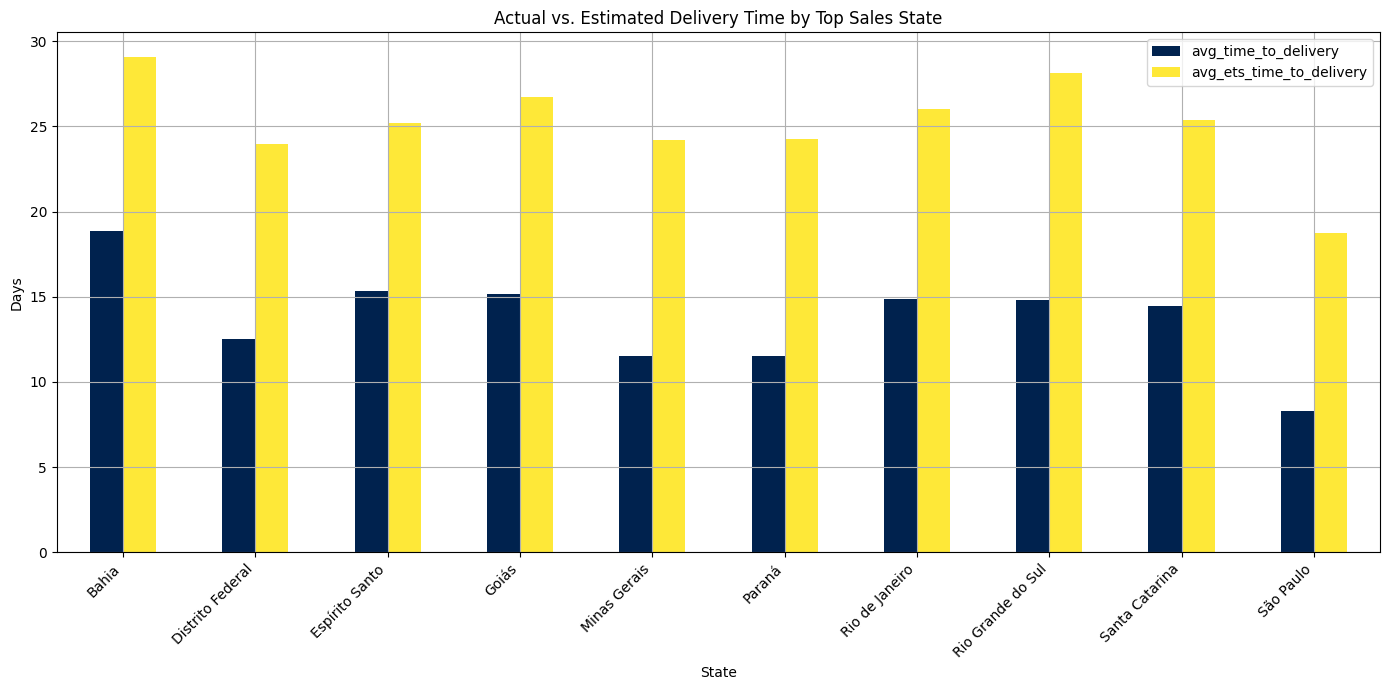

In [37]:
# Adjust state label for better readability


# Generate visualization
avg_time_to_delivery.plot(x='customer_state', kind='bar', figsize=(14, 7), colormap='cividis')

# Add titles
plt.title('Actual vs. Estimated Delivery Time by State')
plt.xlabel('State')
plt.ylabel('Days')
plt.title('Actual vs. Estimated Delivery Time by Top Sales State')
plt.grid(True)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Observation:**
*   Consistent Overestimation: The estimated delivery time consistently exceeds the actual delivery time by approximately 10 days, suggesting a substantial buffer in the estimation model.

*   High Variability in Delivery Time: Actual delivery times fluctuate significantly, with a wide range from around 8 to nearly 20 days.

*   Regional Disparities: Delivery speeds show considerable regional variation. São Paulo demonstrates the fastest shipping times, while Bahia has a delivery time that is roughly double, indicating a significant regional disparity in logistics efficiency.
**Further Investigation:**
*   Volume of orders in a given state might lead to more optimized routes.
*   Correlation between longer delivery times and lower review scores in specific states.


## Oder Processing Time

<Figure size 1400x700 with 0 Axes>

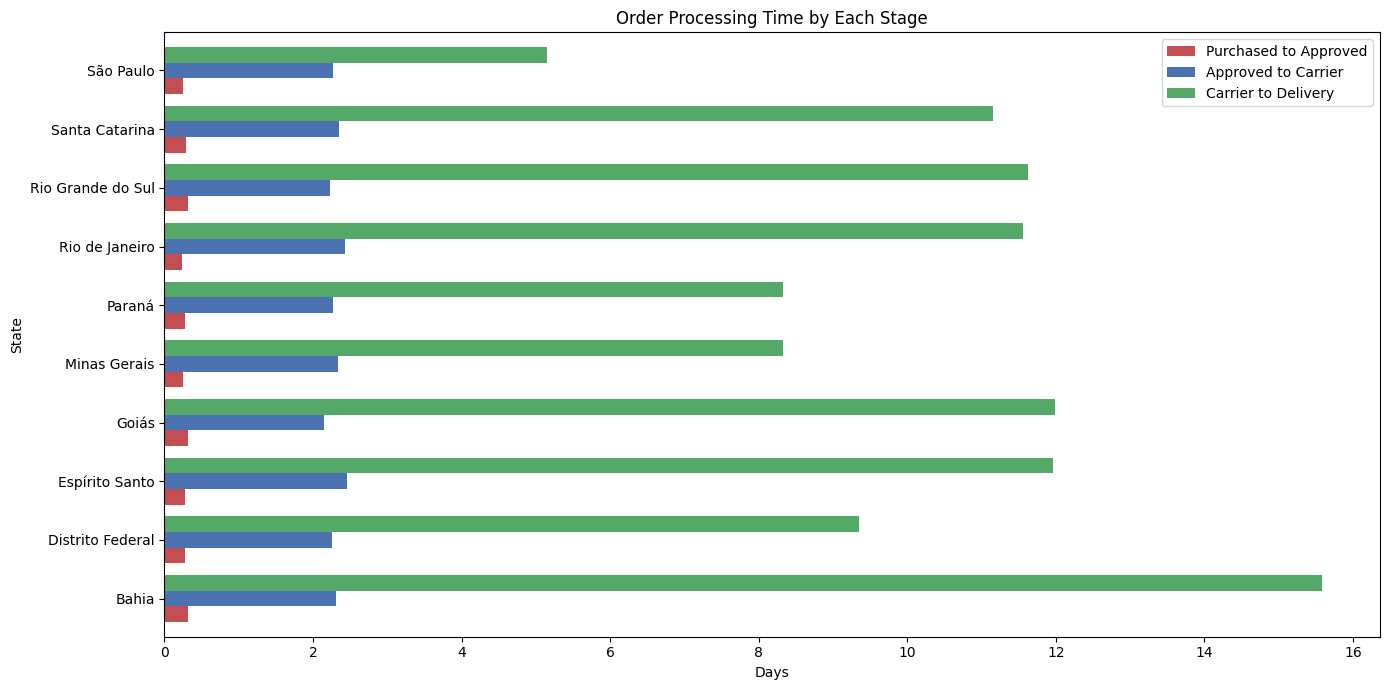

In [38]:
plt.figure(figsize=(14, 7))
order_time_by_stage.plot(x='customer_state', kind='barh', figsize=(14, 7), color=['#c44f53', '#4c72b1', '#55a968'], width=.8)

plt.title('Order Processing Time by Each Stage')
plt.xlabel('Days')
plt.ylabel('State')

plt.tight_layout()
plt.show()

**Observation**
*   Shipping time from carrier to delivery share the same fluctution duration with the last graph suggesting that Carrier is the most unstable unit in this whole process. This variability could stem from various factors outside the seller's direct control, such as:
Logistical challenges in different regions (e.g., road conditions, remote areas).
Efficiency and capacity of different shipping carriers.
Customs or local regulations.
Unexpected events like weather delays.
*   The first two stages share common processing time implies stability is a positive sign for the platform and its sellers.

## Average Delivery Time

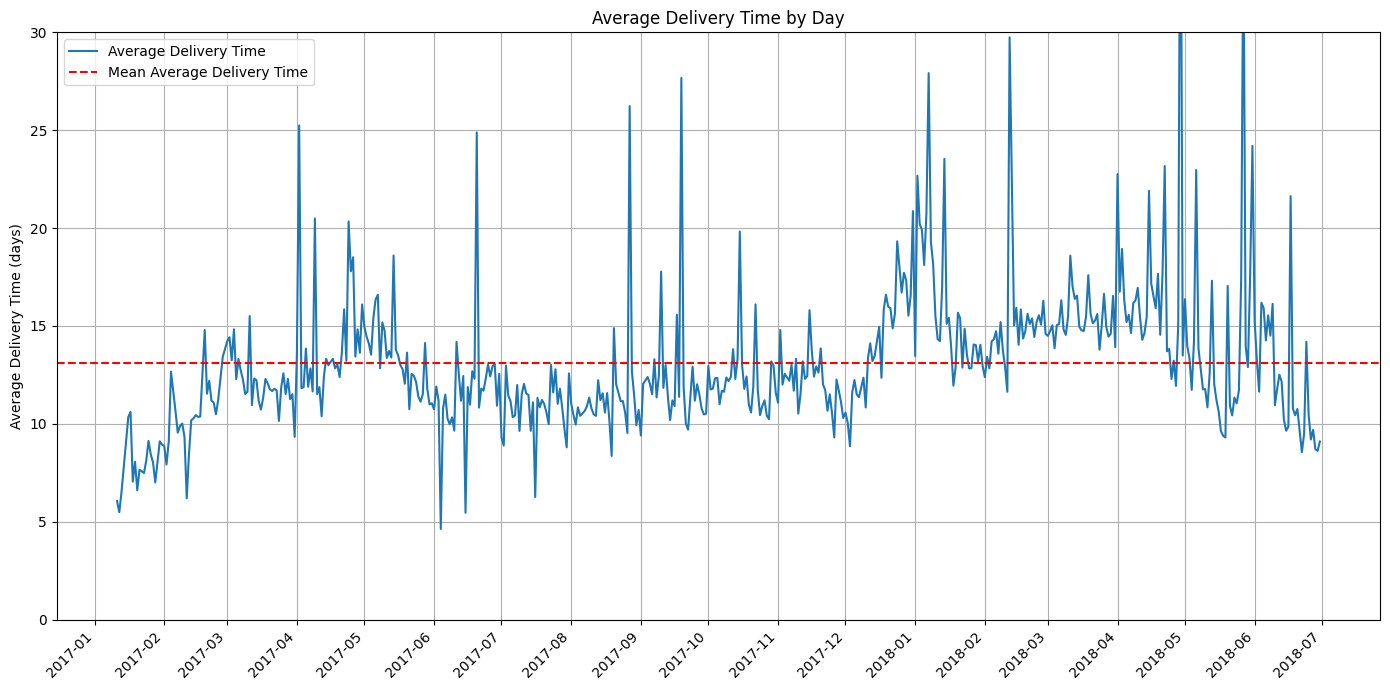

In [72]:
# Generating scatter chart on avarage delivery time daily
import matplotlib.dates as mdates
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(avg_delivery_time_by_day['date']), avg_delivery_time_by_day['avg_delivery_time'], label='Average Delivery Time')
plt.axhline(avg_delivery_time_by_day['avg_delivery_time'].mean(), color='r', linestyle='--', label='Mean Average Delivery Time')
plt.title('Average Delivery Time by Day')
plt.ylabel('Average Delivery Time (days)')
plt.legend()
plt.grid(True)
plt.ylim(0, 30)

# Set xticks on the x axis to every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Observation**
*   The rolling average shows a general upward trend in average delivery time over the period from early 2017 to mid-2018.
*   Periods, characterized by consistent peaks or troughs, suggest the influence of external factors like holidays, promotional periods, or logistics disruptions, all of which warrant further investigation.

# Customer Review  
Order score rating could show customer satisfication and reveal further improvements.

## Data Preparation  
Let's see the overall satisfication and dig in the relation between review score and delivery time.

In [79]:
view_table('order_reviews', 5).iloc[:, 1:]

,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [81]:
review_score_count_query = """
  SELECT
    review_score,
    COUNT(*) AS review_count
  FROM
    order_reviews
  GROUP BY
    review_score
"""

review_score_count = pd.read_sql_query(review_score_count_query, db_connection)
review_score_count.head()

,review_score,review_count
0,1,11424
1,2,3151
2,3,8179
3,4,19142
4,5,57328


In [85]:
fulfillment_time_between_review_query = """
  SELECT
    review_score,
    AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)) AS avg_fulfillment_time
  FROM
    orders
    JOIN order_reviews USING (order_id)
  GROUP BY
    review_score
"""

fulfillment_time_between_review = pd.read_sql_query(fulfillment_time_between_review_query, db_connection)
fulfillment_time_between_review.head()

,review_score,avg_fulfillment_time
0,1,21.311419
1,2,16.660580
2,3,14.261962
3,4,12.312356
4,5,10.688605


## Review Scores Distribution

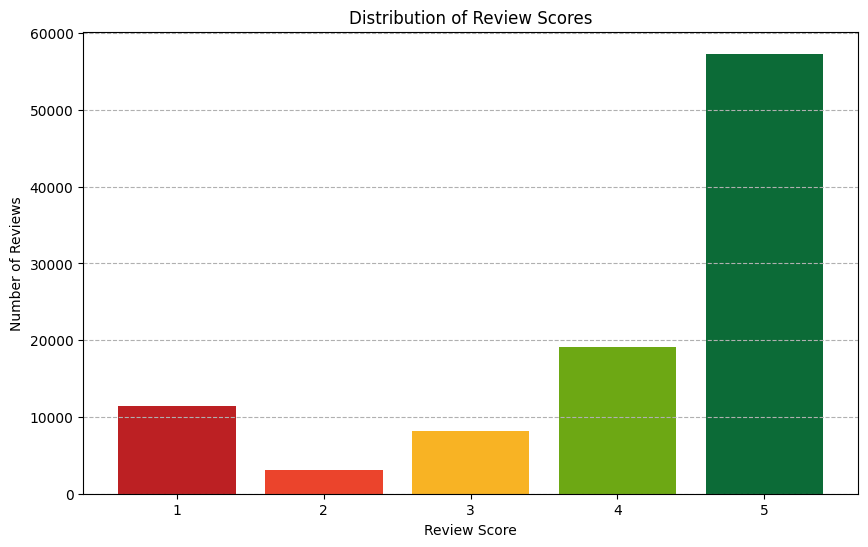

In [84]:
plt.figure(figsize=(10, 6))
plt.bar(review_score_count['review_score'], review_score_count['review_count'], color=['#BC2023', '#EB442C', '#F8B324', '#6da814', '#0C6B37'])
plt.xlabel('Review Score')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Review Scores')
plt.xticks(review_score_count['review_score']) # Ensure all review scores are shown as ticks
plt.grid(axis='y', linestyle='--')
plt.show()

**Observation:**
*   There are a large amount of positive reviews which significantly distributed on maximum score. Deeper analysis can determine major factors for a good fulfillment.
*   Approximately 20k customers were having online shopping experiences from bad to avarage. These are the potential field for improvements.

**Observations and Potential Insights:**

*   The majority of reviews are positive, heavily skewed towards the maximum score (5), indicating high overall customer satisfaction. Analyzing these positive reviews could reveal key drivers of good experiences.

*   Around 20,000 customers gave scores between 1 and 3, highlighting areas for improvement. Investigating these lower-scoring reviews can help identify specific issues and opportunities to enhance customer experience.

## Delivery Time to Customer Satisfication

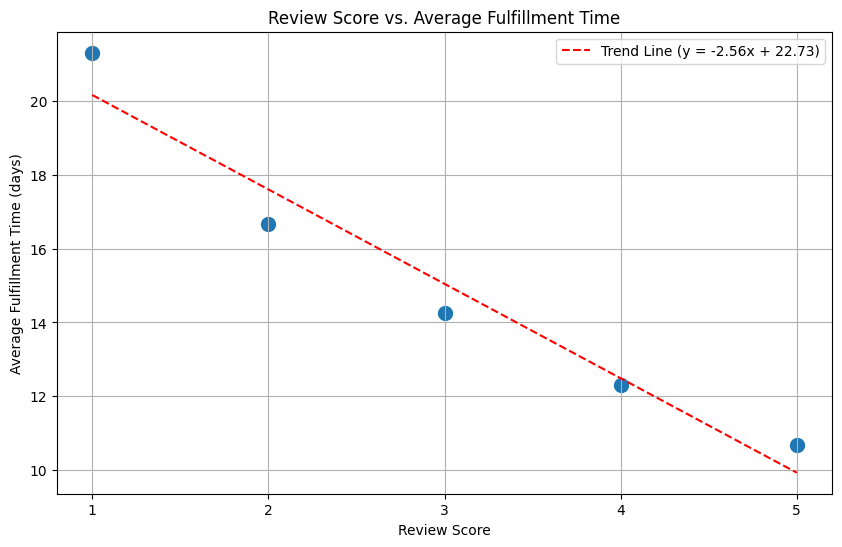

In [91]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(fulfillment_time_between_review['review_score'], fulfillment_time_between_review['avg_fulfillment_time'], s=100) # Increased marker size

# Add a trend line
X = fulfillment_time_between_review['review_score'].values.reshape(-1, 1)
y = fulfillment_time_between_review['avg_fulfillment_time'].values.reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)

trend_X = np.array([X.min(), X.max()]).reshape(-1, 1)
trend_y = model.predict(trend_X)

plt.plot(trend_X, trend_y, color='red', linestyle='--', label=f'Trend Line (y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f})')

plt.xlabel('Review Score')
plt.ylabel('Average Fulfillment Time (days)')
plt.title('Review Score vs. Average Fulfillment Time')
plt.legend()
plt.grid(True)

# Set x-axis ticks to show whole numbers
plt.xticks(fulfillment_time_between_review['review_score'])

plt.show()

**Observation:**
* There is a clear negative correlation between review score and average fulfillment time, indicating that longer delivery times tend to result in lower review scores.

# Notebook Summary

This notebook analyzed the Brazilian e-commerce public dataset from Olist Store, focusing on order volume trends, product pricing, category performance, delivery times, and customer reviews.

Key findings include:

*   **Order Volume:** The platform experienced overall growth with noticeable seasonal peaks. Daily and hourly trends show higher activity during weekday working hours and a drop-off on weekends. São Paulo, Rio de Janeiro, and Minas Gerais are the top states by order volume.
*   **Order Items Pricing:** Most orders consist of a single item, and there is a concentration of orders with lower total values and freight costs.
*   **Revenue Breakdown by Category:** A few product categories dominate in both sales value and item count. There is a generally linear relationship between item count and total value per category.
*   **Order Timestamp & Fulfillment Time:** Estimated delivery times consistently exceed actual delivery times. Delivery times show significant regional variation, with São Paulo having the fastest deliveries. The "Carrier to Delivery" stage is the most variable part of the fulfillment process. Average delivery time showed an upward trend from early 2017 to mid-2018.
*   **Customer Review:** The majority of reviews are positive, but a notable portion are negative to average, representing an opportunity for improvement. There is a negative correlation between review score and average fulfillment time.

Overall, the analysis highlights areas of strength, such as overall platform growth and high satisfaction for faster deliveries, as well as areas for potential improvement, such as addressing longer delivery times in certain regions and understanding the factors behind lower review scores. Further investigation into specific categories, regional logistics, and customer feedback can provide more targeted insights for optimizing operations and enhancing customer experience.